마지막까지 배울 점이 많은 대회입니다. 캐글 단톡방에도 한번 얘기가 나온적이 있는 것 같습니다만, <br>
feature 간의 순서만 바뀌어도 결과값이 조금 다르게 나오는 거 같습니다. <br>
제 Leaderboard상의 점수가 나온 Feature가 정확히 기억이 안나서 ('haversine_dist_low'포함여부가 정확하지 않음)
몇번 다시 돌려봤음에도 완전히 똑같은 점수는 나오지 않았습니다.
그래서 먼저 양해를 구하고 싶은 점은 제 현재 Leaderboard 상의 score는 104991.88329이지만, 아래 커널을 돌리시면, <br>
Private score 기준으로 'haversine_dist_low'를 빼시면, 105438.35505<br>
포함해서 돌리시면, 104252.30328이 나오게 됩니다. <br>
기록을 정확하게 해놨어야 했는데, 그러지 못한 점 양해 부탁드립니다. <br>
(지금 커널로 돌린 점수는 104747.22031가 나오게 되네요.왜 그런지 잘 모르겠습니다;)
<br><br>
저는 아래 커널들을 참고하여 진행하였습니다. <br>
이외 저에게 많은 가르침을 주신 모든 분들께 감사말씀드립니다!!<br>

* https://www.kaggle.com/dhznsdl/house-price-regression-python
* https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline
* https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12
* https://www.kaggle.com/yeonmin/default-eda-stacking-introduction
* https://www.kaggle.com/ivoryrabbit/a-note-on-using-a-single-model-xgboost
* https://www.kaggle.com/tmheo74/geo-data-eda-and-feature-engineering

In [1]:
# 분석 기본 도구
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
%matplotlib inline


In [2]:

def haversine_array(lat2, lng2):
    lat1, lng1 = 47.63, -122.22
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    diffs = np.expm1(predictions) - np.expm1(labels)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('rmse_exp', np.sqrt(avg))

def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 6), grid_model.best_params_))
    return grid_model.best_estimator_

def zipcode_groupby(train, test, group_col, colname, agg_method) :
    new_colname = 'price_per'+'_'+colname
    #new_colname2 = colname+'mean'
    
    train[new_colname] = train['price']/train[colname]
    price_per_temp = train.groupby([group_col])[new_colname].agg(agg_method)
    price_per_temp.columns = ['{}_{}'.format(new_colname, m) for m in agg_method]
    price_per_temp = price_per_temp.reset_index()
    #price_per_temp.rename(columns={'mean':new_colname2}, inplace=True)
    train = pd.merge(train, price_per_temp, how='left', on=group_col)
    test = pd.merge(test, price_per_temp, how='left', on=group_col)
    
    del train[new_colname]
    
    return train, test

def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t

def category_feature_distribution(train, col, target='price'):
    fig, ax = plt.subplots(1, 2, figsize=(16,4))
    
    for c in sorted(train[col].unique()):
        sns.distplot(train.loc[train[col]==c, target], ax=ax[0])
    ax[0].legend(sorted(train[col].unique()))
    ax[0].set_title(f'{col} {target} distribution')

    sns.boxplot(x=col, y=target, data=train, ax=ax[1])
    ax[1].set_title(f'{col} vs {target}')
    
    plt.show()
    
def haversine_array_new(lat1_raw, lng1_raw, lat2, lng2):
    lat1, lng1 = lat1_raw, lng1_raw
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def haversine_array_low(lat2, lng2):
    lat1, lng1 = 47.382, -122.247
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [4]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
data = pd.merge(train, test, how='outer')

train_raw = train
train_len = len(train)

data['min_haver'] = np.nan
for i in range(len(data)) :
    temp_lat, temp_lng = data[['lat', 'long']].loc[i,'lat'], data[['lat', 'long']].loc[i,'long']
    temp_all_df = data.drop([i], 0)
    temp_coord_df = haversine_array_new(temp_lat, temp_lng, temp_all_df['lat'], temp_all_df['long'])
    temp_min = temp_coord_df.min()
    data.loc[i,'min_haver'] = temp_min    

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_al

/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)
/tmp/ipykernel_30436/2509778493.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_all_df = data.drop([i], 0)


In [5]:
######## zipcode 라벨링
train = data.iloc[:train_len,:]
test = data.iloc[train_len:,:]

for df in [train, test] :
    #df['zip_1'] = df['zipcode'].apply(lambda x : str(x)[2]).astype(int)
    df['zip_12'] = df['zipcode'].apply(lambda x : str(x)[2:4]).astype(int)
    #df['zip_2'] = df['zipcode'].apply(lambda x : str(x)[3]).astype(int)
    #df['zip_23'] = df['zipcode'].apply(lambda x : str(x)[3:5]).astype(int)
    #df['zip_3'] = df['zipcode'].apply(lambda x : str(x)[4]).astype(int)

le = LabelEncoder()

le.fit(train['zipcode'])
le.fit(test['zipcode'])

train['zipcode'] = le.transform(train['zipcode'])
test['zipcode'] = le.transform(test['zipcode'])

train['sqft_total_size'] = train['sqft_above'] + train['sqft_basement'] # 총 주거 면적    
test['sqft_total_size'] = test['sqft_above'] + test['sqft_basement']

####### zipcode_groupby 단가 변수 생성
train['price_per_land_area'] = train['price'] / (train['sqft_living'])
price_per_ft = train.groupby(['zipcode'])['price_per_land_area'].agg({'mean', 'std', 'count'}).reset_index()
train = pd.merge(train, price_per_ft, how='left', on='zipcode')
test = pd.merge(test, price_per_ft, how='left', on='zipcode')
del train['price_per_land_area']

####### train, test set 지정

X_train = train.drop(['id', 'price'], 1)
y_train = train['price']
y_train = np.log1p(y_train)
X_test = test.drop(['id', 'price'], axis=1)

####### KMeans Clustering
km_n = 120
km = KMeans(n_clusters=km_n, random_state=2019)
km.fit(X_train[['lat', 'long']])#

######## 이외 Feature Engineering
for df in [X_train, X_test]:
    df['date(new)'] = df['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400) # 날짜 줄 세우기
    df['how_old'] = df['date'].apply(lambda x: x[:4]).astype(int) - df[['yr_built', 'yr_renovated']].max(axis=1) # 얼마나 됐는지 연식
    df['yr_built'] = df['yr_built'] - 1900 # 건축년도 1900년도로부터 얼마나 됐는지 
    
    # sqft 관련
    df['sqft_diff'] = df['sqft_living15'] - df['sqft_living']
    df['sqft_living_lot_diff'] = df['sqft_lot'] - df['sqft_living']
    #df['sqft_living_lot_div'] = df['sqft_living'] / df['sqft_lot']
    del df['sqft_lot15'], df['yr_renovated'], df['sqft_lot'],df['date']#, df['waterfront']#, df['view'], df['condition']
    
    #df['sqft_living_all'] = df['sqft_living'] + df['sqft_living15']
    #df['living_div'] = df['sqft_living15'] / df['sqft_living_all']    
    
    # 방 관련
    df['sqft_bedrooms'] = df['sqft_total_size'] / (df['bedrooms'] + 1) # 방하나당 면적 : bedrooms가 0인 자료 꽤 있음 
    
    
    # KMeans 클러스터링
    km_col_name = 'km'+ '_' + str(km_n)
    df[km_col_name] = km.predict(df[['lat', 'long']])
    
    # 레벨 관련
    df['sum_level'] = df['grade'] + df['view'] + df['condition'] # 등급 총합
    df['multi_level'] = df['grade'] * (df['view']+1) * df['condition']
    
    df['condition_2'] = df['condition'].apply(lambda x : 0 if x < 3 else x)
    df['sum_level_2'] = df['view'] + df['condition_2'] + df['grade']
    
    del df['condition_2']
    
    df['low_cond']=df['condition'].apply(lambda x : 0 if x <= 2 else 1)
    df['low_view'] = df['view'].apply(lambda x : 0 if x == 0 else 1)
    df['low_bath'] = df['bathrooms'].apply(lambda x: 0 if x < 1 else 1)
    df['low_bed'] = df['bedrooms'].apply(lambda x : 0 if x ==1 else 1)
    df['low_grade'] = df['grade'].apply(lambda x : 0 if x <= 6 else 1)
    df['low_all'] = (df['low_cond'] + df['low_view']+df['low_bath'] + df['low_bed'] + df['low_grade']) + df['waterfront']
    
    del df['low_cond'], df['low_view'], df['low_bath'], df['low_bed'], df['low_grade']
   
    # 거리 관련
    df['haversine_dist']= haversine_array(df['lat'], df['long']) # 중심가로부터의 거리 (haversine_dist)
    df['haversine_dist_low'] = haversine_array_low(df['lat'], df['long'])
    #df['min_haver_multi'] = df['min_haver'] * df['haversine_dist'] 

# 로그화
for i in ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_total_size', 'sqft_bedrooms'] :
    X_train[i] = np.log1p(X_train[i])
    X_test[i] = np.log1p(X_test[i])
    
X_train = X_train.drop([13522, 4123],0)
y_train = y_train.drop([13522, 4123],0)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

print(len(X_train.columns), X_train.columns)
print([item for item in X_train.columns if item not in train_raw.columns])

/tmp/ipykernel_30436/1622870655.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zip_12'] = df['zipcode'].apply(lambda x : str(x)[2:4]).astype(int)
/tmp/ipykernel_30436/1622870655.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zip_12'] = df['zipcode'].apply(lambda x : str(x)[2:4]).astype(int)
/tmp/ipykernel_30436/1622870655.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

33 Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'min_haver', 'zip_12',
       'sqft_total_size', 'mean', 'std', 'count', 'date(new)', 'how_old',
       'sqft_diff', 'sqft_living_lot_diff', 'sqft_bedrooms', 'km_120',
       'sum_level', 'multi_level', 'sum_level_2', 'low_all', 'haversine_dist',
       'haversine_dist_low'],
      dtype='object')
['min_haver', 'zip_12', 'sqft_total_size', 'mean', 'std', 'count', 'date(new)', 'how_old', 'sqft_diff', 'sqft_living_lot_diff', 'sqft_bedrooms', 'km_120', 'sum_level', 'multi_level', 'sum_level_2', 'low_all', 'haversine_dist', 'haversine_dist_low']


/tmp/ipykernel_30436/1622870655.py:93: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = X_train.drop([13522, 4123],0)
/tmp/ipykernel_30436/1622870655.py:94: FutureWarning: In a future version of pandas all arguments of Series.drop except for the argument 'labels' will be keyword-only.
  y_train = y_train.drop([13522, 4123],0)


In [6]:
X_train['price'] = y_train
km2 = KMeans(n_clusters=120, random_state=2019)
km2.fit(X_train[['price', 'km_120']])
X_train['km_pre'] = km2.predict(X_train[['price', 'km_120']])
X_train.drop('price', 1, inplace=True)
X_train_km_pre = X_train[['km_120', 'km_pre']].groupby('km_120')['km_pre'].mean().reset_index()
X_test = X_test.merge(X_train_km_pre, how='left', on='km_120')

/tmp/ipykernel_30436/517690007.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train.drop('price', 1, inplace=True)


>** 신규 Feature 설명**
* min_haver : 이웃 중 가장 가까운 곳과의 거리 (허태명님의 커널 참고)
* zip_12 : zipcode 중 98을 제외한 1,2번째 숫자 (허태명님의 커널 참고)
* sqft_total_size : sqft_above + sqft_basement
* std, mean, count : std, mean은 zipcode별 price/sqft_total_size의 표준편차, 평균, count는 zipcode별 count 횟수
* date(new), how_old : (DongGyu Lee님의 커널 참고)
* sqft_diff : sqft_living15 - sqft_living
* sqft_living_lot_diff : sqft_lot - sqft_living
* sqft_bedrooms : sqft_living / (sqft_bedrooms + 1)
* sum_level : grade + view + condition
* multi_level : grade * view * condition
* sum_level_2 : view + condition(3미만인 것은 0으로 치환) + grade
* low_all : condtion(2이하는 0, 나머지는 1) + view(0인것은 0 나머지는 1) + bath(1미만은 0 나머지는 1) + bed(1이면 0 나머지는 1) + grade(6이하면 0, 나머지는 1) + waterfront
* haversine_dist : 47.63, -122.22으로부터 거리
* haversine_dist_low : 47.382, -122.247
* km_120 : 120개로 KMeans 클러스터링 lat, long
* km_pre : price와 km_120 KMeans 클러스터링 후 test set에는 merge

multi_level까지는 대부분 아실거라 생각합니다. 그 이후 나오는 것들에 대해 시각화를 진행하고자 합니다.

> 1) haversine_dist, haversine_dist_low

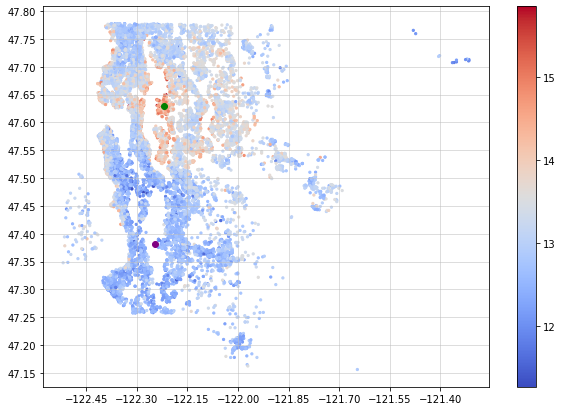

In [7]:
plt.figure(figsize=(10,7))
plt.scatter(data['long'], data['lat'], s=5, c=np.log1p(data['price']), cmap='coolwarm')
plt.yticks(np.arange(47, 47.81, 0.05))
plt.xticks(np.arange(-122.6, -121.2, 0.15))
plt.grid(color='#BDBDBD', linestyle='-', linewidth=0.5)
plt.colorbar()
plt.scatter(-122.22, 47.63, color='green')
plt.scatter(-122.247, 47.382, color='purple')

* 위를 보시면, 제가 기준점으로 쓴 점들이 초록색과 보라색으로 보입니다. 
* 저는 제가 보기에 가장 빨간색과 파란색(가격이 높고 낮은) 점이 많이 있는 곳의 중간의 lat, long을 기준점으로 삼았습니다.
* 가격이 낮은 곳으로부터 거리는 모르겠지만 가격이 높은 것으로부터 거리는 점수 상승에 많은 기여를 했습니다.
* 이 커널을 참고하시면 더 많은 정보를 얻으실 수 있습니다. https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

> sum_level_2, low_all

<AxesSubplot:xlabel='low_all', ylabel='price'>

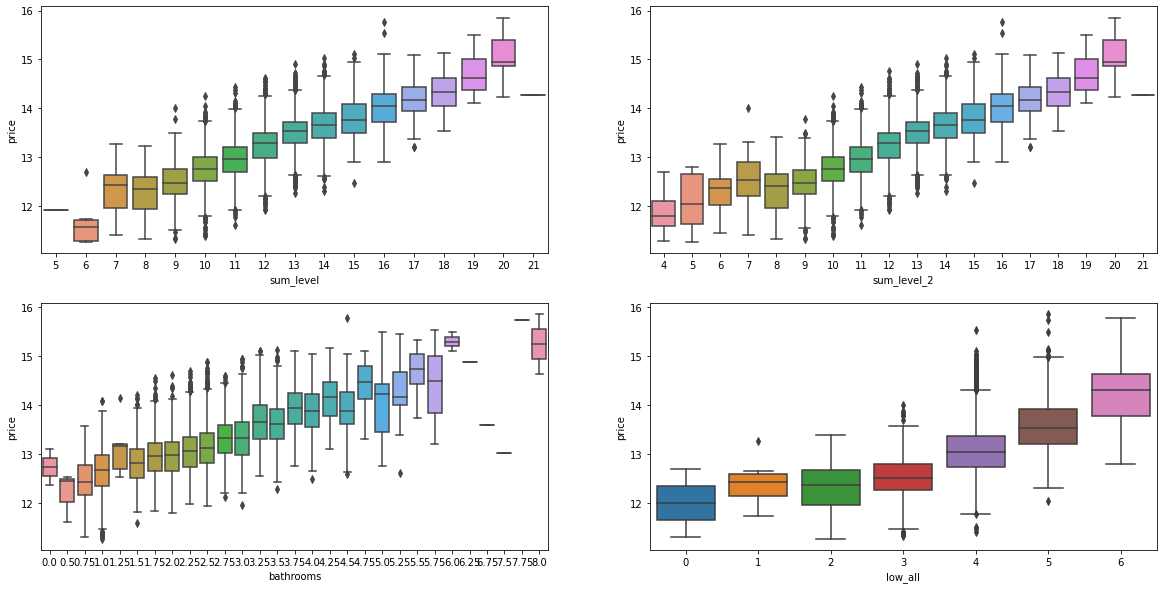

In [8]:
X_train['price'] = y_train
f, ax =  plt.subplots(2,2, figsize=(20, 10))
sns.boxplot(x='sum_level', y='price', data=X_train, ax=ax[0,0])
sns.boxplot(x='sum_level_2', y='price', data=X_train, ax=ax[0,1])
sns.boxplot(x='bathrooms', y='price', data=X_train, ax=ax[1,0])
sns.boxplot(x='low_all', y='price', data=X_train, ax=ax[1,1])

* 저는 이번 대회 내내 oof를 통해서 제가 설계하는 모델이 log 변환후 12미만 가격을 제대로 예측하지 못 한다는 걸 알게됐습니다.
* 이에 어떻게 하면, 12미만 가격의 집값을 예측할지 고민하며 만든 feature가 sum_level_2와 low_all입니다.
* 점수상승에 그렇게까지 큰 기여를 했는지는 의문이네요;

> km_120

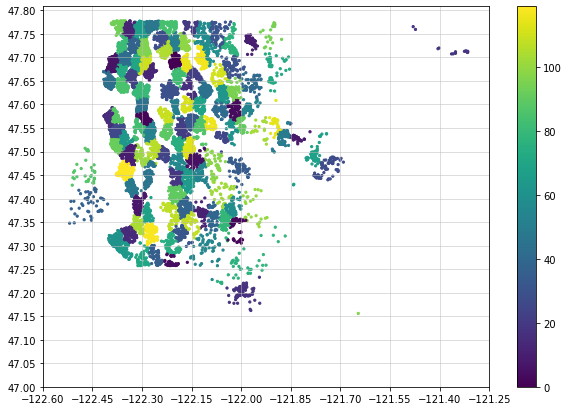

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(X_train['long'], X_train['lat'], s=5, c=X_train['km_120'])
plt.yticks(np.arange(47, 47.81, 0.05))
plt.xticks(np.arange(-122.6, -121.2, 0.15))
plt.grid(color='#BDBDBD', linestyle='-', linewidth=0.5)
plt.colorbar()

- 저는 허태명님의 커널과 달리 좀 더 많은 클러스터로 나눠보았습니다 (120)
- 그리고 이를 바탕으로 km120과 price를 kmeans 후 X_test에 km120 기준으로 merge를 해보았습니다

In [10]:
X_train.drop('price', 1, inplace=True)

/tmp/ipykernel_30436/811781944.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train.drop('price', 1, inplace=True)


In [11]:
%%time
dtrain = lgb.Dataset(X_train, label=y_train)
dtest  = lgb.Dataset(X_test)

lgb_params = {
    'boosting_type': 'gbdt',
    'objective':'regression',
    'num_leave' : 1,
    'learning_rate' : 0.03,
    'max_depth' : 6,
    'colsample_bytree' : 0.4,
    'subsample' : 0.4,
    'max_bin' : 80,
    'gpu_id':0,         
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'refit':True,
    'metric' : 'rmse',
    'seed' : 2019
}

cv_lgb_output = lgb.cv(lgb_params, dtrain, num_boost_round=5000, nfold=5, early_stopping_rounds=200, verbose_eval=100,stratified=False)

print('best_num_rounds :',len(cv_lgb_output['rmse-mean']))
print('best_cv_score :', cv_lgb_output['rmse-mean'][-1])

best_num_rounds = len(cv_lgb_output['rmse-mean'])

model_lgb = lgb.train(lgb_params, dtrain, num_boost_round=best_num_rounds)
lgb_pred_log = model_lgb.predict(X_test)
lgb_pred = np.expm1(lgb_pred_log)


/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: predictor keyword has been found in `params` and will be ignored.
Please use predictor argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[Ligh

/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Start training from score 13.047273
[LightGBM] [Info] Start training from score 13.047349
[LightGBM] [Info] Start training from score 13.047284
[LightGBM] [Info] Start training from score 13.049407
[LightGBM] [Info] Start training from score 13.050107
[100]	cv_agg's rmse: 0.177892 + 0.000949447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[1300]	cv_agg's rmse: 0.156723 + 0.000742045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[16:01:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:01:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:01:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:01:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:01:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } 

/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[100]	train-rmse:1.64920	train-rmse_exp:556529.20000	test-rmse:1.64964	test-rmse_exp:556623.63750
[200]	train-rmse:0.27347	train-rmse_exp:204166.15000	test-rmse:0.28090	test-rmse_exp:211227.95625
[300]	train-rmse:0.15072	train-rmse_exp:105960.63437	test-rmse:0.16930	test-rmse_exp:127940.33281
[400]	train-rmse:0.13784	train-rmse_exp:88169.48906	test-rmse:0.16272	test-rmse_exp:117265.57344
[500]	train-rmse:0.13003	train-rmse_exp:80868.68594	test-rmse:0.16036	test-rmse_exp:113899.94687
[600]	train-rmse:0.12371	train-rmse_exp:75750.40000	test-rmse:0.15878	test-rmse_exp:112081.07500
[700]	train-rmse:0.11816	train-rmse_exp:71805.12813	test-rmse:0.15771	test-rmse_exp:111038.34219
[800]	train-rmse:0.11350	train-rmse_exp:68437.42812	test-rmse:0.15695	test-rmse_exp:110229.47969
[900]	train-rmse:0.10911	train-rmse_exp:65457.78438	test-rmse:0.15646	test-rmse_exp:109710.81563
[1000]	train-rmse:0.10511	train-rmse_exp:62756.31016	test-rmse:0.15600	test-rmse_exp:109125.35937
[1100]	train-rmse:0.10140	

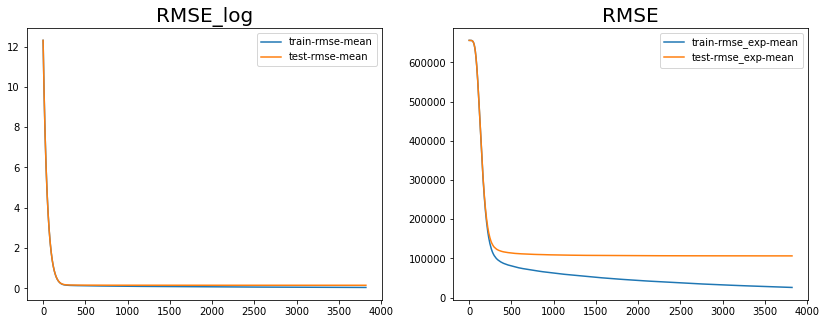

In [12]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',        
    'silent': True,               
    'seed' : 1984
}



# transform
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

# cross validation
cv_output = xgb.cv(xgb_params,
                   dtrain,                        
                   num_boost_round=5000,         
                   early_stopping_rounds=150,    
                   nfold=5,                      
                   verbose_eval=100,             
                   feval=rmse_exp,               
                   maximize=False,
                   show_stdv=False,              
                   )

# scoring
best_rounds = cv_output.index.size
score = round(cv_output.iloc[-1]['test-rmse_exp-mean'], 2)

print(f'\nBest Rounds: {best_rounds}')
print(f'Best Score: {score}')

model = xgb.train(xgb_params, dtrain, num_boost_round=best_rounds)
xgb_pred_log = model.predict(dtest)
xgb_pred = np.expm1(xgb_pred_log)

# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot(ax=ax1)
ax1.set_title('RMSE_log', fontsize=20)
cv_output[['train-rmse_exp-mean', 'test-rmse_exp-mean']].plot(ax=ax2)
ax2.set_title('RMSE', fontsize=20)

plt.show()


In [14]:
ensemble_pred = np.vstack([lgb_pred, xgb_pred]).mean(0)
sample_submission = pd.read_csv('./sample_submission.csv')
submission = pd.DataFrame(data = {'id': test['id'], 'price': ensemble_pred})
submission.to_csv('submission_ensemble.csv', index=False)

In [18]:
!pip install kaggle

In [19]:
print("kaggle submit private score : ",106334.3319 ," / public score : ", 101810.19628)

Traceback (most recent call last):
  File "/home/doeun/anaconda3/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/home/doeun/anaconda3/lib/python3.9/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/home/doeun/anaconda3/lib/python3.9/site-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /home/doeun/.kaggle. Or use the environment method.


In [ ]:
!